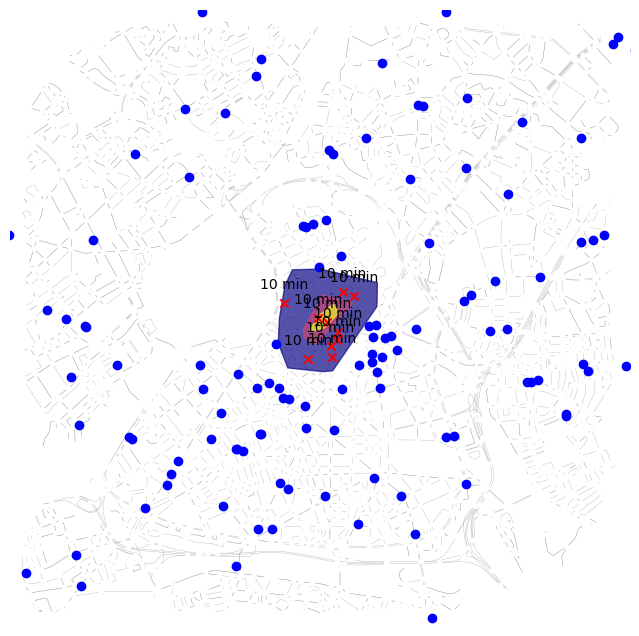

In [1]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import MultiPoint, Polygon, Point
import matplotlib.pyplot as plt
import networkx as nx
import osmnx as ox

# Casino location
casino_location = (50.63852, 3.059534)

# Load competitor data
competitors_data = pd.read_excel('geocoding.xlsx')

# Create a graph from the casino location
Graph = ox.graph_from_point(casino_location, network_type='drive', dist=3000)
center_node = ox.distance.nearest_nodes(Graph, casino_location[1], casino_location[0])


trip_times = [10,3,5]  # in minutes
iso_polys = []
for trip_time in sorted(trip_times, reverse=True):
    subgraph = nx.ego_graph(Graph, center_node, radius=trip_time, distance='time')
    node_points = ox.utils_graph.graph_to_gdfs(subgraph, edges=False)['geometry'].unary_union
    polygon = node_points.convex_hull if isinstance(node_points, MultiPoint) else node_points
    iso_polys.append(polygon)

# Prepare colors for different zones
iso_colors = ox.plot.get_colors(n=len(trip_times), cmap='plasma', start=0, return_hex=True)

# Create the figure for visualization
fig, ax = ox.plot_graph(Graph, show=False, close=False, bgcolor='w', edge_linewidth=0.2, edge_color='#999999')
for polygon, color in zip(iso_polys, iso_colors):
    if isinstance(polygon, Polygon):
        ax.fill(*polygon.exterior.xy, color=color, alpha=0.7)

for _, row in competitors_data.iterrows():
    competitor_location = Point(row['long'], row['lat'])
    in_isochrone = False

    for trip_time, polygon in zip(trip_times, iso_polys):
        if polygon.contains(competitor_location):
            ax.scatter(row['long'], row['lat'], c='red', marker='x')
            ax.annotate(f'{trip_time} min', (row['long'], row['lat']), textcoords="offset points", xytext=(0,10), ha='center')
            in_isochrone = True
            break

    if not in_isochrone:
        ax.scatter(row['long'], row['lat'], c='blue', marker='o')

plt.show()

In [6]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import MultiPoint, Polygon, Point
import matplotlib.pyplot as plt
import networkx as nx
import osmnx as ox
import alphashape
import folium
import osmnx as ox
import folium
from shapely.geometry import Point, Polygon
from shapely.ops import unary_union, polygonize
from concave_hull import concave_hull_indexes
import numpy as np
from geopy.distance import geodesic

# Casino location
casino_location = (43.49601894103733, -0.7976213842399038)

# Load competitor data
competitors_data = pd.read_excel('geocoding.xlsx')

num_mins = 15

G = ox.graph_from_point(casino_location, dist=2000, network_type='drive')
G = ox.add_edge_speeds(G)
G = ox.add_edge_travel_times(G)
center_node = ox.distance.nearest_nodes(G, casino_location[1], casino_location[0])
subgraph = nx.ego_graph(G, center_node, radius=num_mins*60, distance='time_travel')
isochrone = ox.graph_to_gdfs(subgraph, edges=False)
points = [Point(lon, lat) for lon, lat in zip(isochrone['geometry'].x, isochrone['geometry'].y)]
isochrone = ox.graph_to_gdfs(subgraph, edges=False)
isochrone_polygon = isochrone.unary_union.convex_hull

m = folium.Map(location=casino_location, zoom_start=13)

#folium.GeoJson(Polygon(list(isochrone_polygon.exterior.coords))).add_to(m)

point_array = np.array([[point.x, point.y] for point in points])
idxes = concave_hull_indexes(
    point_array[:, :2],
    #length_threshold=1,
    concavity=1,
)

polygon_coords = point_array[idxes, ::-1].tolist()

folium.Polygon(locations=polygon_coords, color='blue', fill=True, fill_color='blue', fill_opacity=0.4).add_to(m)

def calculate_distance(loc1, loc2):
    return geodesic(loc1, loc2).kilometers

# Distance maximale (estimation basée sur le rayon de l'isochrone)
max_distance = 10.0  # À ajuster selon vos besoins

filtered_competitors = []

for _, row in competitors_data.iterrows():
    competitor_location = (row['lat'], row['long'])
    distance = calculate_distance(casino_location, competitor_location)

    if distance <= max_distance:
        filtered_competitors.append(row)

# Utilisez 'filtered_competitors' au lieu de 'competitors_data' pour la vérification avec isochrone_polygon
for _, row in pd.DataFrame(filtered_competitors).iterrows():
    competitor_location = Point(row['long'], row['lat'])
    
    if isochrone_polygon.contains(competitor_location):
        # Ajouter un marqueur rouge pour les concurrents à l'intérieur de l'isochrone
        folium.Marker(location=(row['lat'], row['long']), 
                      popup=f'{num_mins} min', 
                      icon=folium.Icon(color='red')).add_to(m)
    else:
        # Ajouter un marqueur bleu pour les concurrents à l'extérieur de l'isochrone
        folium.Marker(location=(row['lat'], row['long']), 
                      icon=folium.Icon(color='blue')).add_to(m)


# Adding markers for the center and points within the concave hull
folium.Marker(location=casino_location, popup='Center Point', icon=folium.Icon(color='red')).add_to(m)

# Display the map
m

In [3]:
import io

from PIL import Image
 
img_data = m._to_png(5)

img = Image.open(io.BytesIO(img_data))

img.save('my_map.png')

In [9]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import MultiPoint, Polygon, Point
import matplotlib.pyplot as plt
import networkx as nx
import osmnx as ox
import alphashape
import folium
import osmnx as ox
import folium
from shapely.geometry import Point, Polygon
from shapely.ops import unary_union, polygonize
from concave_hull import concave_hull_indexes
import numpy as np
from geopy.distance import geodesic

# Casino location
casino_location = (43.49601894103733, -0.7976213842399038)

# Load competitor data
competitors_data = pd.read_excel('geocoding.xlsx')

num_mins = 15

G = ox.graph_from_point(casino_location, dist=5000, network_type='drive')
G = ox.add_edge_speeds(G)
G = ox.add_edge_travel_times(G)
center_node = ox.distance.nearest_nodes(G, casino_location[1], casino_location[0])
subgraph = nx.ego_graph(G, center_node, radius=num_mins*60, distance='time_travel')
isochrone = ox.graph_to_gdfs(subgraph, edges=False)
points = [Point(lon, lat) for lon, lat in zip(isochrone['geometry'].x, isochrone['geometry'].y)]
isochrone = ox.graph_to_gdfs(subgraph, edges=False)
isochrone_polygon = isochrone.unary_union.convex_hull

m = folium.Map(location=casino_location, zoom_start=13)

#folium.GeoJson(Polygon(list(isochrone_polygon.exterior.coords))).add_to(m)

point_array = np.array([[point.x, point.y] for point in points])
idxes = concave_hull_indexes(
    point_array[:, :2],
    #length_threshold=1,
    concavity=1,
)

polygon_coords = point_array[idxes, ::-1].tolist()

folium.Polygon(locations=polygon_coords, color='blue', fill=True, fill_color='blue', fill_opacity=0.4).add_to(m)

def calculate_distance(loc1, loc2):
    return geodesic(loc1, loc2).kilometers

# Distance maximale (estimation basée sur le rayon de l'isochrone)
max_distance = 10.0  # À ajuster selon vos besoins

filtered_competitors = []

for _, row in competitors_data.iterrows():
    competitor_location = (row['lat'], row['long'])
    distance = calculate_distance(casino_location, competitor_location)

    if distance <= max_distance:
        filtered_competitors.append(row)

for _, row in pd.DataFrame(filtered_competitors).iterrows():
    competitor_location = Point(row['long'], row['lat'])
    nearest_node = ox.distance.nearest_nodes(G, row['long'], row['lat']) 
    if nearest_node in subgraph.nodes:
        folium.Marker(location=(row['lat'], row['long']), 
                      popup=f'{num_mins} min', 
                      icon=folium.Icon(color='red')).add_to(m)
    else:
        # Add a blue marker for competitors outside the isochrone
        folium.Marker(location=(row['lat'], row['long']), 
                      icon=folium.Icon(color='blue')).add_to(m)

# Adding markers for the center and points within the concave hull
folium.Marker(location=casino_location, popup='Center Point', icon=folium.Icon(color='red')).add_to(m)

# Display the map
m